### Refs
- [RDKit Documentation](https://www.rdkit.org/docs/GettingStartedInPython.html)
- [PubChem](https://pubchem.ncbi.nlm.nih.gov/) - find SDF files for molecules
- [YouTube Tutorial](https://www.youtube.com/watch?v=NozaWUkJ3YM)

### Workflow Suggestions
> After modifying classes from `src` directory, **Restart NoteBook Kernel** is required 
- Recommended action after changing files in `src`: Restart -> Run All

## Imports

In [6]:
from src.core.compound import MBCompound
from src.loader import MBLoader
from src.utils.renderer import Renderer
from src.utils.ui import Theme
from src import DIAMAG_COMPOUND_ATOMS_SUBDIR
from src.core.bond_match import MBSubstructMatcher, BondMatchCandidate


## RDkit Diamag Calcs


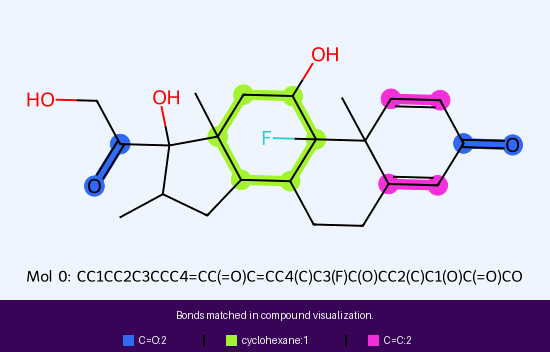

In [7]:
from collections import Counter
from typing import DefaultDict
from collections import defaultdict

from src.constants.bond_types import RELEVANT_BOND_TYPES
from src.loader import MBLoader, MBMolecule
from tests.core.bond_match.bond_match_test_data import BOND_MATCH_TEST_CASES

failures: list[str] = []

mols: list[MBMolecule] = []
highlightAtomLists: list[list[int]] = []
highlightAtomGroupsPerMol: list[dict[str, list[int]]] = []
matches_counters: list[Counter[str]] = []

for idx, bond_type_test in enumerate(BOND_MATCH_TEST_CASES):
    mol: MBMolecule = MBLoader.MolFromSmiles(smiles=bond_type_test.SMILES)
    mols.append(mol)
    candidates: list[BondMatchCandidate] = []

    for bt in RELEVANT_BOND_TYPES:
        hits = mol.GetSubstructMatches(smarts=bt.SMARTS)
        if not hits:
            continue

        prio = int(getattr(bt, "prio", 0))
        for h in hits:
            candidates.append(
                BondMatchCandidate(
                    formula=bt.formula,
                    prio=prio,
                    atoms=tuple(int(x) for x in h),
                )
            )

    # post-processing: self-overlap + priorytety
    final_hits_by_formula, matches_counter, groups_atoms, atoms_to_highlight = MBSubstructMatcher.Postprocess(
        candidates=candidates,)

    # renderer inputs (tak jak wcześniej)
    highlightAtomLists.append(sorted(atoms_to_highlight))
    highlightAtomGroupsPerMol.append({k: sorted(v) for k, v in groups_atoms.items()})
    matches_counters.append(matches_counter)

    x = 1

# Render: highlightAtomLists length == len(mols)
display(
    Renderer(Theme.LoFi).GetMoleculesGridImg(
        mols=[m.ToRDKit() for m in mols],
        highlightAtomLists=highlightAtomLists,
        highlightAtomGroupsPerMol=highlightAtomGroupsPerMol,
        matchesCountersPerMol=matches_counters,
        size=(550, 300),
        mols_per_row=1,
        label="Bonds matched in compound visualization.",
        showLegend=True,
    )
)


### Aromaticity check

In [8]:
from rdkit.Chem import MolFromSmiles
from rdkit import Chem

mol = MolFromSmiles("C1=COC=CC1=O")
mol.GetAtomWithIdx(3).GetIsAromatic()

True